<a href="https://colab.research.google.com/github/Shubhamd13/NLP/blob/main/9_2_Feature_Map_%2B_BLIP_Student_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 01: Vision Encoder + Feature Mapping + Decoder

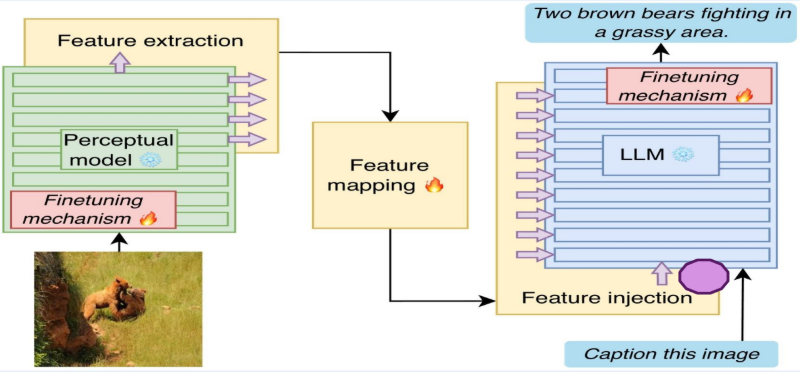

### Utility

In [1]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import re

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def display_patches(patches, patch_size, channels=3, max_patches=300):
    num_patches = min(len(patches), max_patches)
    patches = patches[:num_patches]

    grid_size = int(np.ceil(np.sqrt(num_patches)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_patches):
        patch = patches[i].reshape(patch_size, patch_size, channels)

        # Normalize if float
        if np.issubdtype(patch.dtype, np.floating):
            patch_min, patch_max = patch.min(), patch.max()
            if patch_max > patch_min:
                patch = (patch - patch_min) / (patch_max - patch_min)  # normalize to 0-1
            patch = (patch * 255).astype(np.uint8)

        if channels == 1:
            patch = patch.squeeze(-1)
            axes[i].imshow(patch, cmap='gray')
        else:
            axes[i].imshow(patch)

        axes[i].axis('off')

    for j in range(num_patches, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Setup

In [2]:
np.random.seed(999)

image_size = 256
patch_size = 32
img_encoder_embed_dim = 128
decoder_embed_dim = 64
mlp_dim = 128
max_text_len = 7

### Step 1: Vocabulary

In [3]:
texts = ["a photo of a dog", "a photo of a cat", "caption this image", "this is a dog"]
def tokenize(text): return re.findall(r'\w+', text.lower())
def build_vocab(texts):
    vocab, idx = {}, 0
    for text in texts:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    vocab['<bos>'] = idx; idx += 1        # Beginning of sequence
    vocab['<eos>'] = idx; idx += 1        # End of sequence
    vocab['<pad>'] = idx; idx += 1        # Padding token
    vocab['[decode]'] = idx; idx += 1     # Special token for image-grounded text decoding
    return vocab

vocab = build_vocab(texts)
vocab_size = len(vocab)
print(vocab)
inv_vocab = {i: t for t, i in vocab.items()}

# Get IDs for special tokens
BOS_ID = vocab['<bos>']
EOS_ID = vocab['<eos>']
PAD_ID = vocab['<pad>']
DECODE_ID = vocab['[decode]']

# Token Embedding
np.random.seed(999)
W_token_embed = np.random.randn(vocab_size, decoder_embed_dim) * 0.01

{'a': 0, 'photo': 1, 'of': 2, 'dog': 3, 'cat': 4, 'caption': 5, 'this': 6, 'image': 7, 'is': 8, '<bos>': 9, '<eos>': 10, '<pad>': 11, '[decode]': 12}


### Step 2: Load Image and Create Patches

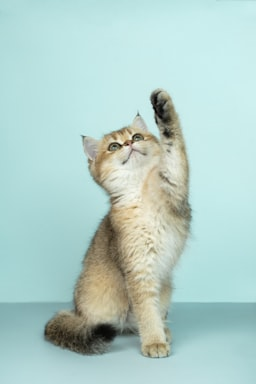


Reshaped image shape: (256, 256, 3)


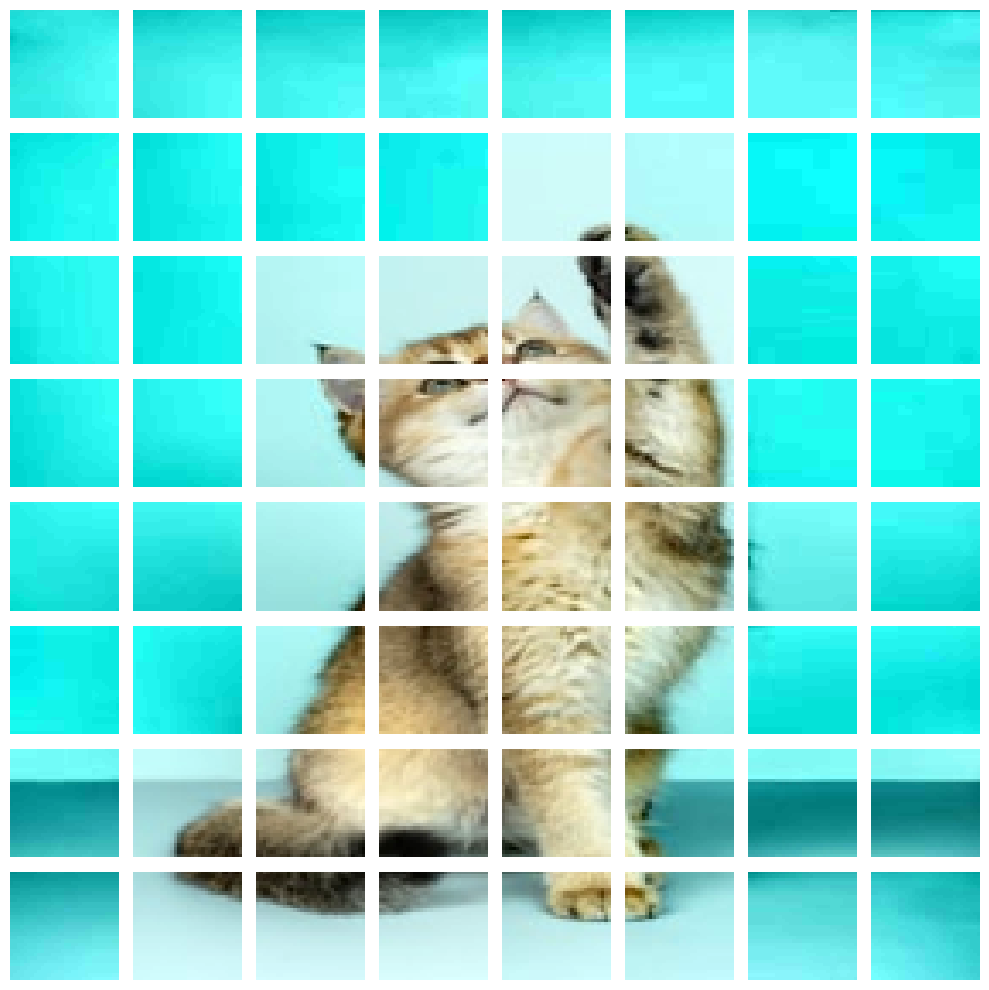

64
3072


In [8]:
def download_image(url, size=(image_size, image_size)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    display(img)
    return np.array(img.resize(size)) / 255.0

image_url = "https://images.unsplash.com/photo-1592194996308-7b43878e84a6?ixlib=rb-4.0.3&auto=format&fit=crop&w=256&q=80"
img_input = download_image(image_url)
print(f"\nReshaped image shape: {img_input.shape}")

# Create Image Patches
def get_patches(image, patch_size):
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch.reshape(-1))  # flatten each patch
    return np.array(patches)

# Get Patches
patches = get_patches(img_input, patch_size)

# Show Patches
display_patches(patches, patch_size, channels=img_input.shape[2])


num_patches = patches.shape[0]
patch_dim = patches.shape[1]
print(f"{num_patches}")
print(f"{patch_dim}")


### Step 3: Vision Encoder

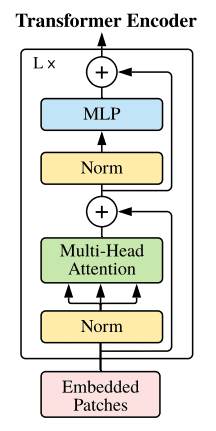


$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$


In [9]:
# Applies Layer Normalization
def layer_norm(x, eps=1e-6):
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    return  (x - mean) / (std + eps)

# Computes softmax probabilities
def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

# Approximation of GELU activation function
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

In [11]:
np.random.seed(999)

# Image Encoder Weights
W_patch_embed = np.random.randn(patch_dim, img_encoder_embed_dim) * 0.01
cls_token_vision = np.random.randn(1, img_encoder_embed_dim) * 0.01 # [CLS]

# Self-Attention & MLP weights for encoder and decoder
W_Q = np.random.randn(img_encoder_embed_dim, img_encoder_embed_dim) * 0.01
W_K = np.random.randn(img_encoder_embed_dim, img_encoder_embed_dim) * 0.01
W_V = np.random.randn(img_encoder_embed_dim, img_encoder_embed_dim) * 0.01
W1 = np.random.randn(img_encoder_embed_dim, mlp_dim) * 0.01
b1 = np.zeros(mlp_dim)
W2 = np.random.randn(mlp_dim, img_encoder_embed_dim) * 0.01
b2 = np.zeros(img_encoder_embed_dim)


# Image Encoder
def image_encoder(image_patches_flat, cls_token):
    patch_embeds = image_patches_flat @ W_patch_embed
    sequence_input = np.vstack([cls_token, patch_embeds])

    x = layer_norm(sequence_input)

    Q = x @ W_Q
    K = x @ W_K
    V = x @ W_V

    scores = Q @ K.T / np.sqrt(img_encoder_embed_dim)

    attn_weights = softmax(scores)
    attn_output = attn_weights @ V

    x = sequence_input + attn_output

    x_norm_mlp = layer_norm(x)
    h_mlp = gelu(x_norm_mlp @ W1 + b1)
    mlp_output = h_mlp @ W2 + b2
    encoder_output = x + mlp_output
    return encoder_output

encoded_img_seq = image_encoder(patches, cls_token_vision)
img_embedding = encoded_img_seq[0:1, :]

print(img_embedding)
print(img_embedding.shape)

[[ 0.14242819 -0.02760885  0.21245883  0.08573351 -0.14391583  0.02683426
   0.14670228 -0.04678772 -0.13853215  0.03783525 -0.20400243  0.02417665
  -0.03540343  0.01726692  0.09397237  0.04852798 -0.3127113   0.10955991
   0.05253009  0.11101179  0.06595544  0.01880283 -0.03994118 -0.06766878
  -0.01032763 -0.08609984  0.05023451  0.03734987 -0.00576136 -0.03573422
   0.06447726 -0.02803845 -0.07635747 -0.06797125 -0.00163317  0.11355629
  -0.09084565 -0.09659286 -0.03753776 -0.22376312  0.18254365  0.16646737
  -0.01353864 -0.11970773 -0.16847559 -0.03138647  0.19444392 -0.00302178
  -0.08484059  0.09548383  0.02212051 -0.01344967  0.04239585  0.11963954
  -0.14436329  0.08127117  0.06853129  0.05975698 -0.02703902 -0.03198497
   0.03764315  0.11685247 -0.0074769   0.09902326 -0.11513695  0.20442073
  -0.04757996 -0.02365222  0.01899928  0.08804024 -0.00261539  0.16882356
  -0.0434931  -0.00295983  0.0744788   0.08802004  0.0806591   0.03369735
  -0.15313666  0.08365999 -0.07976508 

### Step 4: Feature Mapping using MLP

Image Features of dimension X → MLP layer → Image features of dimension X'

In [13]:
np.random.seed(999)
feature_map_hidden_dim = decoder_embed_dim * 2
W_map1 = np.random.randn(feature_map_hidden_dim, feature_map_hidden_dim) * 0.01
b_map1 = np.zeros(feature_map_hidden_dim)
W_map2 = np.random.randn(feature_map_hidden_dim, decoder_embed_dim) * 0.01
b_map2 = np.zeros(decoder_embed_dim)

# Feature Mapping
def feature_mapping_mlp(X):

    ###<--- Write code here
    h =   X @ W_map1 + b_map1                          # Perform XW1 + b1
    #####

    h = gelu(h)
    mapped_feature = h @ W_map2 + b_map2
    mapped_feature = layer_norm(mapped_feature)
    return mapped_feature

# Function call
mapped_features = feature_mapping_mlp(img_embedding)
print(mapped_features)
print(mapped_features.shape)


[[ 0.861278   -0.86143849 -1.22102388 -1.1898978  -0.4939021   0.57947253
   1.22127346 -1.25081964 -1.08964783  0.97179683 -0.48644678  0.66255888
  -0.31596075  0.00312601 -0.67437082  0.58208889  0.72552416 -0.28050791
  -1.40773974  1.57360825 -0.99703159  0.63375805  0.73828314  0.336845
  -1.66998377 -0.28100098 -0.52385748  2.46731456  1.53352774  1.57204111
   0.91156679 -0.43994226 -3.00585577  0.41520378  0.41030398 -2.1487533
   0.29472404  1.22060304  0.79414359 -1.5472105  -0.13552272  1.47921243
  -0.57619342  0.21104374 -1.34942488 -0.18092824 -0.90648172  0.22439469
  -0.47618663 -0.1700307   0.75370275  1.00669635  0.20002422  1.13635014
  -0.26967714  0.39278703 -0.09546642 -0.2835941   0.14291669 -0.96456503
   0.59628709  1.00405173  0.08433908 -0.44738544]]
(1, 64)


### Step 5: Decoder

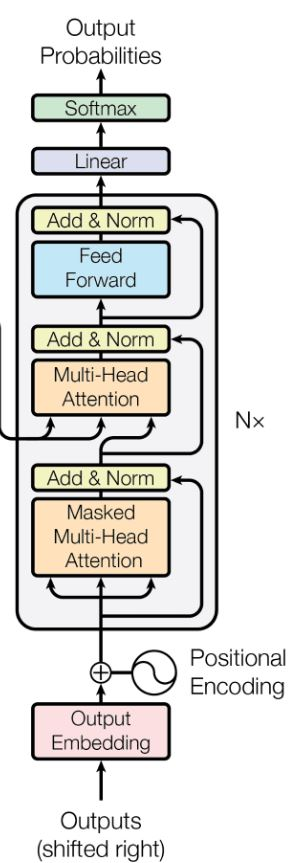

In [14]:
np.random.seed(999)
W_Q_self = np.random.randn(decoder_embed_dim, decoder_embed_dim) * 0.01
W_K_self = np.random.randn(decoder_embed_dim, decoder_embed_dim) * 0.01
W_V_self = np.random.randn(decoder_embed_dim, decoder_embed_dim) * 0.01
W_mlp = np.random.randn(decoder_embed_dim, vocab_size) * 0.01


# Cross-Attention Weights
W_Q_dec = np.random.randn(decoder_embed_dim, decoder_embed_dim) * 0.01
W_K_enc = np.random.randn(decoder_embed_dim, decoder_embed_dim) * 0.01
W_V_enc = np.random.randn(decoder_embed_dim, decoder_embed_dim) * 0.01

# Decoder
def llm_decoder(text_input_embeddings, mapped_features):

    # Causal Self-Attention ---
    x_self_attn_norm = layer_norm(text_input_embeddings)
    Q_self = x_self_attn_norm @ W_Q_self
    K_self = x_self_attn_norm @ W_K_self
    V_self = x_self_attn_norm @ W_V_self
    scores_self = Q_self @ K_self.T / np.sqrt(decoder_embed_dim)

    seq_len_text = scores_self.shape[0]
    mask = np.triu(np.ones((seq_len_text, seq_len_text)), k=1).astype(bool)
    scores_self[mask] = -1e9
    self_attn_weights = softmax(scores_self)
    self_attn_output = self_attn_weights @ V_self
    x = text_input_embeddings + self_attn_output

    # Cross-Attention
    x_cross_attn_norm = layer_norm(x)
    Q_cross = x_cross_attn_norm @ W_Q_dec
    K_cross = mapped_features @ W_K_enc # Keys from mapped visual features
    V_cross = mapped_features @ W_V_enc # Values from mapped visual features

    scores_cross = Q_cross @ K_cross.T / np.sqrt(decoder_embed_dim)
    cross_attn_weights = softmax(scores_cross)
    cross_attn_output = cross_attn_weights @ V_cross
    x = x + cross_attn_output

    # Output logits
    final_hidden = x[-1]
    logits = final_hidden @ W_mlp
    return logits

### Step 6: Forward Pass



If we are doing cross-entropy loss for predicting over 5 words (assume the vocabulary size is 5), the cross-entropy loss for a single prediction is -  


$\mathcal{L} = - \sum_{i=1}^{5} y_{i}\log(\hat{y}_{i})$

Here,

$y_{i}$ = 1 if word $i$ is the true label otherwise 0

$\hat{y}_{i}$ =  model’s predicted probability for word $i$

Because only one $y_{i}$ is 1 (true label), this simplifies to -

$\mathcal{L} = - \log(\hat{y})$

In [15]:
# Loss Calculation (LM Loss)
def compute_lm_loss(predicted_logits, target_token_ids):
    probabilities = softmax(predicted_logits)
    target_prob = probabilities[target_token_ids]
    loss = -np.log(target_prob + 1e-9)
    return loss

In [16]:
np.random.seed(999)

prefix_tokens = ["<bos>", "caption", "this", "image"]
prefix_ids = [vocab[token] for token in prefix_tokens]
gen_ids = prefix_ids.copy()

lm_losses = []

target_text = "a photo of a cat"
target_tokens = tokenize(target_text)
target_ids = [vocab[tok] for tok in target_tokens if tok in vocab] + [EOS_ID]
print(f"Target caption for LM Loss: '{target_text}' (IDs: {target_ids})\n")

for step in range(max_text_len):
    txt_embeds = np.array([W_token_embed[i] for i in gen_ids])

    # Decoder Step with mapped feature

    ###<--- Write code here
    logits =  llm_decoder(txt_embeds, mapped_features)                   # call decoder function with text embedding and mapped feature vector
    #####

    # LM Loss
    if step < len(target_ids):
        tgt_id = target_ids[step]
        loss = compute_lm_loss(logits, tgt_id)
        lm_losses.append(loss)

    # Next Token
    logits += np.random.normal(0, 0.5, size=logits.shape)
    probs = softmax(logits)
    next_id = int(np.argmax(probs))
    gen_ids.append(next_id)

    print(f"Step {step+1}:")
    print("-"*15)
    print(f"Predict: '{inv_vocab[tgt_id]}' \nGenerated: '{inv_vocab[next_id]}' \nProbability: {np.max(probs):.3f} \nLoss: {loss.item():.4f}")
    print("")

# Final Output
tokens = []
for tid in gen_ids[len(prefix_ids):]:
    tok = inv_vocab[tid]
    if tok in ['<bos>', '[decode]']: continue
    if tok == '<eos>': break
    tokens.append(tok)

print("\n--- Generated Caption ---")
print("Token IDs:", gen_ids)
print("Decoded:", " ".join(tokens))

print("\n--- LM Loss ---")
print(f"Avg LM Loss: {np.mean(lm_losses):.4f}" if lm_losses else "No loss calculated.")

Target caption for LM Loss: 'a photo of a cat' (IDs: [0, 1, 2, 0, 4, 10])

Step 1:
---------------
Predict: 'a' 
Generated: 'this' 
Probability: 0.146 
Loss: 2.5581

Step 2:
---------------
Predict: 'photo' 
Generated: '[decode]' 
Probability: 0.174 
Loss: 2.5652

Step 3:
---------------
Predict: 'of' 
Generated: '[decode]' 
Probability: 0.135 
Loss: 2.5714

Step 4:
---------------
Predict: 'a' 
Generated: 'a' 
Probability: 0.117 
Loss: 2.5590

Step 5:
---------------
Predict: 'cat' 
Generated: 'is' 
Probability: 0.143 
Loss: 2.5622

Step 6:
---------------
Predict: '<eos>' 
Generated: 'cat' 
Probability: 0.186 
Loss: 2.5666

Step 7:
---------------
Predict: '<eos>' 
Generated: '<eos>' 
Probability: 0.162 
Loss: 2.5666


--- Generated Caption ---
Token IDs: [9, 5, 6, 7, 6, 12, 12, 0, 8, 4, 10]
Decoded: this a is cat

--- LM Loss ---
Avg LM Loss: 2.5637


# BLIP

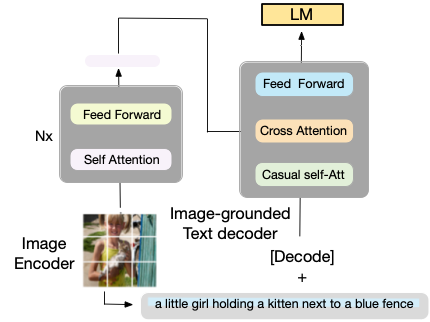

### Utility

In [17]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import re

### Setup

In [18]:
SEED = 42
np.random.seed(SEED)

image_size = 64
patch_size = 8
embed_dim = 64
mlp_dim = 128
max_text_len = 7

### Step 1: Vocabulary

In [19]:
texts = ["a photo of a dog", "a photo of a cat", "caption this image", "this is a dog"]
def tokenize(text): return re.findall(r'\w+', text.lower())
def build_vocab(texts):
    vocab, idx = {}, 0
    for text in texts:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    vocab['<bos>'] = idx; idx += 1        # Beginning of sequence
    vocab['<eos>'] = idx; idx += 1        # End of sequence
    vocab['<pad>'] = idx; idx += 1        # Padding token
    vocab['[decode]'] = idx; idx += 1     # Special token for image-grounded text decoding
    return vocab

vocab = build_vocab(texts)
print(vocab)
inv_vocab = {i: t for t, i in vocab.items()}

# Get IDs for special tokens
BOS_ID = vocab['<bos>']
EOS_ID = vocab['<eos>']
PAD_ID = vocab['<pad>']
DECODE_ID = vocab['[decode]']

# Token Embedding
np.random.seed(SEED)
W_token_embed = np.random.randn(vocab_size, embed_dim) * 0.01

{'a': 0, 'photo': 1, 'of': 2, 'dog': 3, 'cat': 4, 'caption': 5, 'this': 6, 'image': 7, 'is': 8, '<bos>': 9, '<eos>': 10, '<pad>': 11, '[decode]': 12}


### Step 2: Load Image and Create Patches

In [20]:
def download_image(url, size=(64, 64)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(img.resize(size)) / 255.0

img = download_image("https://images.unsplash.com/photo-1518717758536-85ae29035b6d?ixlib=rb-4.0.3&auto=format&fit=crop&w=256&q=80")

def patchify(image, patch_size):
    H, W, C = image.shape
    patches = []
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch.reshape(-1))
    return np.array(patches)

### Step 3: Weight Initialization

In [21]:
np.random.seed(SEED)

patch_dim = patch_size * patch_size * 3
num_patches = (image_size // patch_size) ** 2
vocab_size = len(vocab)

# Vision encoder
W_patch = np.random.randn(patch_dim, embed_dim) * 0.01
cls_token_img = np.random.randn(1, embed_dim) * 0.01
W_Q, W_K, W_V = [np.random.randn(embed_dim, embed_dim) * 0.01 for _ in range(3)]
W1, b1 = np.random.randn(embed_dim, mlp_dim) * 0.01, np.zeros(mlp_dim)
W2, b2 = np.random.randn(mlp_dim, embed_dim) * 0.01, np.zeros(embed_dim)

# Decoder weights
W_token = np.random.randn(vocab_size, embed_dim) * 0.01

# Self-attention in decoder
W_d_Q = np.random.randn(embed_dim, embed_dim) * 0.01
W_d_K = np.random.randn(embed_dim, embed_dim) * 0.01
W_d_V = np.random.randn(embed_dim, embed_dim) * 0.01

# Cross-attention
W_c_Q = np.random.randn(embed_dim, embed_dim) * 0.01
W_c_K = np.random.randn(embed_dim, embed_dim) * 0.01
W_c_V = np.random.randn(embed_dim, embed_dim) * 0.01

# Output layer
W_out = np.random.randn(embed_dim, vocab_size) * 0.01

### Step 4: Vision Encoder

In [22]:
def layer_norm(x, axis=-1, eps=1e-6):
    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    return (x - mean) / (std + eps)

def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [23]:
def transformer_encoder(x):
    x_norm = layer_norm(x)
    Q, K, V = x_norm @ W_Q, x_norm @ W_K, x_norm @ W_V
    scores = Q @ K.T / np.sqrt(embed_dim)
    attn = softmax(scores)
    x = x + attn @ V

    x_norm2 = layer_norm(x)
    h = np.maximum(0, x_norm2 @ W1 + b1)
    return x + h @ W2 + b2

### Step 5: Decoder

In [24]:
def decoder_step(dec_inputs, enc_outputs):
    # Self-Attention
    x_self_norm = layer_norm(dec_inputs)
    Q = x_self_norm @ W_d_Q
    K = x_self_norm @ W_d_K
    V = x_self_norm @ W_d_V
    scores = Q @ K.T / np.sqrt(embed_dim)

    # Apply causal mask
    mask = np.triu(np.ones_like(scores), 1).astype(bool)
    scores[mask] = -1e9
    self_attn = softmax(scores)
    self_out = self_attn @ V

    # Cross-Attention
    x_cross_norm = layer_norm(self_out)
    Q = x_cross_norm @ W_c_Q
    K = enc_outputs @ W_c_K
    V = enc_outputs @ W_c_V
    cross_scores = Q @ K.T / np.sqrt(embed_dim)
    cross_attn = softmax(cross_scores)
    cross_out = cross_attn @ V

    # Output logits

    ###<---- Write code here
    final_hidden =   cross_out[-1:]                 # Get the last embedding from the cross attention output
    #####


    logits = final_hidden @ W_out
    return logits


### Step 6: Forward Pass

In [36]:
# Loss Calculation (LM Loss)
def compute_lm_loss(predicted_logits, target_token_ids):
    probabilities = softmax(predicted_logits)
    print(f"hi")
    print("DEBUG:", predicted_logits.shape, probabilities.shape)

    target_prob = probabilities[0, target_token_ids]
    loss = -np.log(target_prob + 1e-9)

    return float(loss)

In [38]:
np.random.seed(SEED)


# Encode the image
patches = patchify(img, patch_size)
patch_embeds = patches @ W_patch
tokens = np.vstack([cls_token_img, patch_embeds])
enc_output = transformer_encoder(tokens)


# Decode the caption
prefix_tokens = ["[decode]", "caption", "this", "image"]
prefix_ids = [vocab[token] for token in prefix_tokens]
gen_ids = prefix_ids.copy()

lm_losses = []

target_text = "a photo of a cat"
target_tokens = tokenize(target_text)
target_ids = [vocab[tok] for tok in target_tokens if tok in vocab] + [EOS_ID]
print(f"Target caption for LM Loss: '{target_text}' (IDs: {target_ids})\n")

for step in range(max_text_len):
    txt_embeds = np.array([W_token_embed[i] for i in gen_ids])

    # Decoder Step
    logits = decoder_step(txt_embeds, enc_output)

    # LM Loss
    if step < len(target_ids):
        tgt_id = target_ids[step]
        loss = compute_lm_loss(logits, tgt_id)
        lm_losses.append(loss)

    # Next Token
    logits += np.random.normal(0, 0.5, size=logits.shape)


    ###<---- Write code here
    probs =   softmax(logits)                # softmax over logits
    ####

    next_id = int(np.argmax(probs))
    gen_ids.append(next_id)

    print(f"Step {step+1}:")
    print("-"*15)
    print(f"Predict: '{inv_vocab[tgt_id]}' \nGenerated: '{inv_vocab[next_id]}' \nProbability: {np.max(probs):.3f} \nLoss: {loss:.4f}")
    print("")

# Final Output
tokens = []
for tid in gen_ids[len(prefix_ids):]:
    tok = inv_vocab[tid]
    if tok in ['<bos>', '[decode]']: continue
    if tok == '<eos>': break
    tokens.append(tok)

print("\n--- Generated Caption ---")
print("Token IDs:", gen_ids)
print("Decoded:", " ".join(tokens))

print("\n--- LM Loss ---")
print(f"Avg LM Loss: {np.mean(lm_losses):.4f}" if lm_losses else "No loss calculated.")

Target caption for LM Loss: 'a photo of a cat' (IDs: [0, 1, 2, 0, 4, 10])

hi
DEBUG: (1, 13) (1, 13)
Step 1:
---------------
Predict: 'a' 
Generated: 'this' 
Probability: 0.138 
Loss: 2.5646

hi
DEBUG: (1, 13) (1, 13)
Step 2:
---------------
Predict: 'photo' 
Generated: 'image' 
Probability: 0.193 
Loss: 2.5656

hi
DEBUG: (1, 13) (1, 13)
Step 3:
---------------
Predict: 'of' 
Generated: 'caption' 
Probability: 0.206 
Loss: 2.5640

hi
DEBUG: (1, 13) (1, 13)
Step 4:
---------------
Predict: 'a' 
Generated: 'is' 
Probability: 0.133 
Loss: 2.5646

hi
DEBUG: (1, 13) (1, 13)
Step 5:
---------------
Predict: 'cat' 
Generated: 'of' 
Probability: 0.120 
Loss: 2.5645

hi
DEBUG: (1, 13) (1, 13)
Step 6:
---------------
Predict: '<eos>' 
Generated: 'is' 
Probability: 0.131 
Loss: 2.5653

Step 7:
---------------
Predict: '<eos>' 
Generated: 'cat' 
Probability: 0.153 
Loss: 2.5653


--- Generated Caption ---
Token IDs: [12, 5, 6, 7, 6, 7, 5, 8, 2, 8, 4]
Decoded: this image caption is of is cat

--- L